In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime
from pubchempy import Compound
from scipy.spatial.distance import cdist
from math import radians, sin, cos, sqrt, atan2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize
from geopy.distance import geodesic
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [3]:
#adore_chemicals_df = pd.read_csv('adore_dataset/chemicals')
#adore_processed_df = pd.read_csv('adore_dataset/processed')
#adore_taxonomy_df = pd.read_csv('adore_dataset/taxonomy')
adore_pc_df = pd.read_csv('adore_dataset/processed/ecotox_mortality_processed.csv')
anglia_df = pd.read_csv('lat_long_anglia.csv')
chemical_info_df = pd.read_csv('Table_B_chemical_information.csv')
use_groups_df = pd.read_csv('Table_C_use_groups_and_mode_of_action_information_for_chemicals.csv')
fish_ecotox_df = pd.read_csv('Table_F_ecotoxicity_data_fish.csv')
anglia_fish_pops = pd.read_csv('more_fish/population.csv')
easting_northing_fish = pd.read_csv('easting_northing_fish.csv')
top_variables = pd.read_csv('top_variables.tsv',sep='\t')
top_chems_fish = pd.read_csv('component_correlations_popsandchems.tsv',sep='\t')
top_RGCCA = pd.read_csv('top_RGCCA.tsv',sep='\t')

/var/folders/v1/ymptnwwx3x1b7_mw0nns09wr0000gn/T/ipykernel_989/2986022364.py:4: DtypeWarning: Columns (30,31,32,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  adore_pc_df = pd.read_csv('adore_dataset/processed/ecotox_mortality_processed.csv')


In [4]:
for col in top_RGCCA.columns:
    print(col)

weights_list = top_RGCCA['weight.component1'].tolist()
absolute_weights = []

for weight in weights_list:
    new_weight = abs(weight)
    absolute_weights.append(new_weight)
    print(new_weight)

top_RGCCA['absolute values weights'] = absolute_weights
top_RGCCA.to_csv('new_weights_RGCCA.csv')

variable
correlation.component1
correlation.component2
weight.component1
weight.component2
blocks
0.0239629444729134
0.795077308982999
0.229904789035286
0.47913165267224
0.124803963371084
0.263208032068966
0.180396805635539
0.254167342167713
0.421650406150614
0.227837393139924
0.421650406150614
0.299696444195716
0.0372082063410461
0.0344324496714762
0.0977769457381628
0.106295023921959
0.421650406150614
0.130316997094768
0.0977769457381628
0.421650406150614
0.0149626472623624
0.496452401084022
0.143554322639742
0.299173497617167
0.0779285568589936
0.164349124329032
0.140907691154995
0.1985297534825
0.329350539195713
0.177963467329795
0.329350539195713
0.23409247104019
0.0290632776398929
0.0268951380093754
0.0763734347934459
0.083026893682188
0.329350539195713
0.101790423140721
0.0763734347934459
0.329350539195713


In [5]:
#put a unit on LC-50 graph at y axis - Amethyst tomorrow
#label LC-50 these are the most commonly detected 30 pesticides in East Anglia from 2018-2023, a percentage value - Amethyst tomorrow

#why pesticides - they are a big threat to fish - put in abstract - Helen
#delete the previous study bit in abstract - Helen

#overlay fish and sites, remove title, remove labels - Amethyst tomorrow

#change database icon - Ben
#add infograph methods - Ben, Helen
#create accurate methods - Amethyst

#QR stuff - Ben and Amethyst tomorrow

#remove all titles - Amethyst tomorrow
#Save figures as PDF - Amethyst tomorrow

#Figure title summary sentences - Ben, Helen, Yishan

#MOA for 30 chemicals, provide chemical list - Yishan

#Conclusion - edit for our results - Helen tomorrow

#create two figures - one is pesticides, one is fish, average for site-wise, error bar for time-wise - Amethyst
#caption, explaining what is average (it's time-wise and site-wise), add a comment that the fish population data is not frequent enough

#two-three fish populations scatterplot linear regression, use all 30 chemicals + fish pop data
#get r^2 larger than 0.7
#subset original 30 chemical data to concentration, site, date, and compound name long table
#chemicals in rows, time in columns - wide table - Amethyst

#easy way to understand: linear regression between concentration and population, find correlation between
#treat East Anglia as one area to get more data
#run RGCCA again
#add fish population to RGCCA
#add RGCCA results to table or conclusion somewhere
#with RGCCA modeling, first component finds strongest correlation, within that chemicals explain xx% of the variance
#absolute weights

#Yishan send email to printing, make sure the guy is available on Monday berrington print

anglia_df.head()
for col in anglia_df.columns:
    print(col)

print(len(anglia_df['SMC_DESC']))
print(anglia_df['SMPT_LONG_NAME'].unique())
print(len(anglia_df['Compound_Name'].unique()))

Unnamed: 0
Sample_Site_ID
MEAS_DETERMINAND_CODE
SAMP_ID
Screening_Method_Details_Code
SAMP_MATERIAL
SMC_DESC
SAMP_PURPOSE_CODE
PURP_DESC
Sample_datetime
SMPT_LONG_NAME
SMPT_TYPE
SPT_DESC
SMPT_EASTING
SMPT_NORTHING
ARE_CODE
ARE_DESC
SMPT_Generic_TYPE
Screening_Method_Details
Concentration
unit
less_than
CAS_Number
Compound_Name
LOD
USE
method
year
month_and_year
Usages
Pesticide Categories
LAT
LONG
44495
['R.WAVENEY ELLINGHAM MILL' 'R.WENSUM SWEET BRIAR RD.BR.'
 'LONG WOOD SPRING, PINMILL, CHELMONDISTON'
 'NACTON MEADOW SPRING, LEVINGTON' 'R.STIFFKEY WIGHTON BRIDGE'
 'R.GIPPING U/S HORSESHOE WEIR' 'R.BLACKWATER SE OF WEST MERSEA'
 'YARE ESTUARY NORTH OF COBHAM ISLAND GT.YARMOUTH'
 'RUMBURGH CHALK OBS.B/H TM39 417A' 'BOX MILL PLANTATION B/H HALSTEAD'
 'CEDAR HOUSE B/H, SUDBOURNE, SUFFOLK' 'MAR DYKE STIFFORD BRIDGE'
 'HOUSE OF EDEN B/H HOLLESLEY SUFFOLK' 'WEGGS FARM B/H DICKLEBURGH'
 'ORWELL ESTUARY 0.5KM D/S PIN MILL' 'SUTTON HOO SPRING AT SUTTON HOO'
 'R.YARE BUCKENHAM FERRY' 'CATFIELD 

/var/folders/v1/ymptnwwx3x1b7_mw0nns09wr0000gn/T/ipykernel_989/3044832935.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  superblock_top_variables['weights_squared'] = superblock_top_variables['weight.component1'].pow(2)


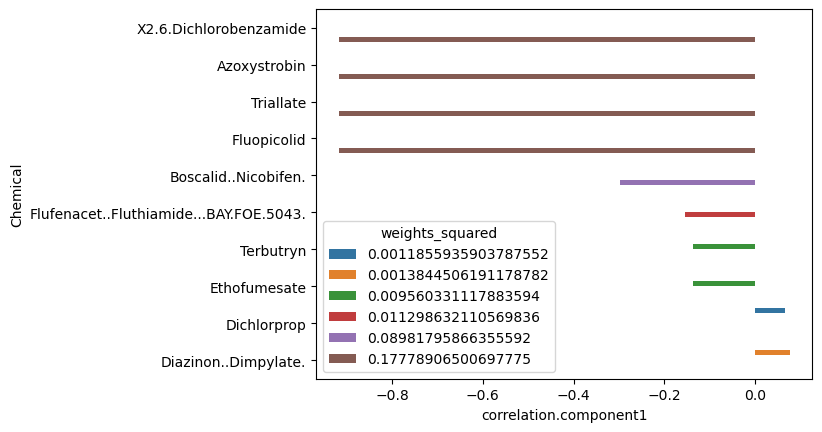

In [6]:
#sort variables by components ascending
top_variables_sorted = top_chems_fish.sort_values(by='correlation.component1')
superblock_top_variables = top_variables_sorted.loc[top_variables_sorted['blocks']=='chems_transformed']
#square weights to get weighted values and add to new column
superblock_top_variables['weights_squared'] = superblock_top_variables['weight.component1'].pow(2)
superblock_top10 = superblock_top_variables.head(10)

#plot again with just top 10 chemicals
sns.barplot(data=superblock_top10,y="Chemical",x='correlation.component1',hue='weights_squared')
superblock_top_variables.head()

superblock_top10.to_csv('superblock_top10.csv')

In [7]:
#adore_pc_df.head()
anglia_df.head()
chemical_info_df.head()
use_groups_df.head()
#fish_ecotox_df.head()
easting_northing_fish.head()

,SURVEY_RANKED_EASTING,SURVEY_RANKED_NORTHING,SV0000000000,LAT,LONG
0,649100,286900,TM4910086900,52.423300,1.662277
1,649100,286900,TM4910086900,52.423300,1.662277
2,649162,287207,TM4916287207,52.426026,1.663416
3,649162,287207,TM4916287207,52.426026,1.663416
4,649162,287207,TM4916287207,52.426026,1.663416


In [8]:
for col in adore_pc_df.columns:
    print(col)

print(adore_pc_df['result_conc1_mean'].unique())
print(adore_pc_df['result_conc1_type'].unique())
adore_pc_df.head()

test_id
reference_number
test_cas
test_location
test_exposure_type
test_control_type
test_media_type
test_application_freq_unit
test_organism_lifestage
result_id
result_effect
result_endpoint
result_obs_duration_mean
result_conc1_type
result_conc1_mean_op
result_conc1_mean
result_conc1_mean_mol
media_ph_mean
media_temperature_mean
tax_all
tax_name
tax_class
tax_order
tax_family
tax_genus
tax_species
tax_gs
species_number
tax_group
tax_pdm_available
tax_eco_climate
tax_eco_ecozone
tax_eco_food
tax_eco_migrate5
tax_eco_migrate2
tax_ps_ampv
tax_ps_ampkap
tax_ps_amppm
tax_lh_amd
tax_lh_lbcm
tax_lh_lpcm
tax_lh_licm
tax_lh_ri#/d
result_conc1_mean_binary
result_conc1_mean_log
result_conc1_mean_mol_log
[1.3600e+03 1.6670e+03 1.4700e+03 ... 1.0549e+00 6.0220e-01 2.4630e-01]
['T' 'F' 'A']


,test_id,reference_number,test_cas,test_location,test_exposure_type,test_control_type,test_media_type,test_application_freq_unit,test_organism_lifestage,result_id,...,tax_ps_ampkap,tax_ps_amppm,tax_lh_amd,tax_lh_lbcm,tax_lh_lpcm,tax_lh_licm,tax_lh_ri#/d,result_conc1_mean_binary,result_conc1_mean_log,result_conc1_mean_mol_log
0,1000105,34,7727-21-1,LAB,NR,I,FW,NR,NR,125798,...,0.3392,364.5,13870.0,0.7,25.1,130.0,NaN,0,3.133539,-2.298323
1,1000112,34,7775-27-1,LAB,NR,I,FW,NR,NR,125805,...,0.3392,364.5,13870.0,0.7,25.1,130.0,NaN,0,3.221936,-2.154806
2,1000118,34,7727-54-0,LAB,NR,I,FW,NR,NR,125811,...,0.3392,364.5,13870.0,0.7,25.1,130.0,NaN,0,3.167317,-2.190979
3,1000125,34,7727-54-0,LAB,NR,I,FW,NR,NR,125818,...,0.3392,364.5,13870.0,0.7,25.1,130.0,NaN,0,1.342423,-4.015874
4,1000130,35,2039-46-5,LAB,NR,I,FW,NR,NR,124331,...,0.3392,364.5,13870.0,0.7,25.1,130.0,NaN,0,0.158362,-5.232043


In [29]:
#add month column to Anglia DF
month_year_list = anglia_df['month_and_year'].tolist()
month_list = []

for month in month_year_list:
    month_list.append(month[:3])

anglia_df['month'] = month_list

anglia_df.head()
print(len(anglia_df['Compound_Name'].unique()))
print(anglia_df['SMPT_LONG_NAME'].unique())
print(len(anglia_df['SMPT_LONG_NAME'].unique()))

287
['R.WAVENEY ELLINGHAM MILL' 'R.WENSUM SWEET BRIAR RD.BR.'
 'LONG WOOD SPRING, PINMILL, CHELMONDISTON'
 'NACTON MEADOW SPRING, LEVINGTON' 'R.STIFFKEY WIGHTON BRIDGE'
 'R.GIPPING U/S HORSESHOE WEIR' 'R.BLACKWATER SE OF WEST MERSEA'
 'YARE ESTUARY NORTH OF COBHAM ISLAND GT.YARMOUTH'
 'RUMBURGH CHALK OBS.B/H TM39 417A' 'BOX MILL PLANTATION B/H HALSTEAD'
 'CEDAR HOUSE B/H, SUDBOURNE, SUFFOLK' 'MAR DYKE STIFFORD BRIDGE'
 'HOUSE OF EDEN B/H HOLLESLEY SUFFOLK' 'WEGGS FARM B/H DICKLEBURGH'
 'ORWELL ESTUARY 0.5KM D/S PIN MILL' 'SUTTON HOO SPRING AT SUTTON HOO'
 'R.YARE BUCKENHAM FERRY' 'CATFIELD MONITORING PIEZOMETER P4'
 'CRAG SPRINGS AT NEWBOURNE FORMER GAUGING STATION'
 'MAYTON WOOD LANDFILL SITE GW B/H 6' 'CHURCH FARM SPRING, WALDRINGFIELD'
 'SPRINGFIELD, FELIXSTOWE B/H' 'THE COTTAGE B/H, FRETTENHAM'
 'HOLYWELLS PARK B/H IPSWICH' 'WICKHAM BISHOPS SPRING NR B1018 RD.'
 'ALBERT BARTLETT B/H 3' 'R.STOUR LANGHAM INTAKE'
 'WELL AT 37 HOLT ROAD, NORTH ELMHAM' 'ICI PAINTS B/H STOWMARKET'
 'SOUT

In [11]:
#get list of mortality causing chemicals which are in both datasets and were tested on rainbow trout
anglia_cas = anglia_df['CAS_Number'].unique().tolist()
#chems_df = anglia_df[['CAS_Number','Compound_Name','month']]
#chems_df.to_csv('chemical_list.csv')

#remove dashes from CAS numbers in chemical df
cas_ecotox_nums = adore_pc_df['test_cas'].tolist()
cas_ea_nums = anglia_df['CAS_Number'].tolist()
cas_ecotox_new = []

for cas in cas_ecotox_nums:
    cas = str(cas)
    cas_ecotox_new.append(cas.replace('-', ''))

cas_strings = []
for cas in cas_ea_nums:
    cas = str(cas)
    cas_strings.append(cas)

anglia_df['CAS_Number'] = cas_strings

#print(anglia_df['CAS_Number'].unique())

adore_pc_df['test_cas']=cas_ecotox_new


#287 chemicals - find in moa dataset, compare different features for each chemical (endpoint, moa)
found_pests = adore_pc_df.loc[adore_pc_df['test_cas'].isin(anglia_cas)]

#find those chems only causing mortality in fish, with LC50 and observed over 96 hours
mortality_chems = found_pests.loc[(found_pests['result_effect']=='MOR') & (found_pests['result_endpoint']=='LC50') & 
                  (found_pests['result_obs_duration_mean']==96)]

fish_chems = mortality_chems.loc[mortality_chems['tax_group']=='fish']
onch_chems = fish_chems.loc[fish_chems['tax_genus']=='Oncorhynchus']
rainbow_chems = onch_chems.loc[onch_chems['tax_species']=='mykiss']

#get list of species names, genus names
species_names = fish_chems['tax_species'].tolist()
genus_names = fish_chems['tax_genus'].tolist()
genus_species = []

#str = genus + species
for species in range(len(species_names)):
    new_string = genus_names[species]+' '+species_names[species]
    #append to new list
    genus_species.append(new_string)
#add back to dataframe in new column
fish_chems['genus_species'] = genus_species

fish_chems.head()

/var/folders/v1/ymptnwwx3x1b7_mw0nns09wr0000gn/T/ipykernel_989/2769031735.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fish_chems['genus_species'] = genus_species


,test_id,reference_number,test_cas,test_location,test_exposure_type,test_control_type,test_media_type,test_application_freq_unit,test_organism_lifestage,result_id,...,tax_ps_amppm,tax_lh_amd,tax_lh_lbcm,tax_lh_lpcm,tax_lh_licm,tax_lh_ri#/d,result_conc1_mean_binary,result_conc1_mean_log,result_conc1_mean_mol_log,genus_species
13,1001707,225,52315078,LAB,S,I,FW,X,NR,112736,...,364.5,13870.0,0.7,25.1,130.0,NaN,1,-2.004365,-7.623771,Cyprinus carpio
17,1001856,268,94757,LAB,S,NR,FW,X,FY,114669,...,364.5,13870.0,0.7,25.1,130.0,NaN,0,2.129690,-3.214761,Cyprinus carpio
79,1024164,859,94757,LAB,NR,C,FW,NR,YY,10815,...,364.5,13870.0,0.7,25.1,130.0,NaN,0,1.984527,-3.359924,Cyprinus carpio
165,1032934,2077,60571,LAB,R,S,FW,NR,NR,6387,...,364.5,13870.0,0.7,25.1,130.0,NaN,1,-0.221849,-5.802670,Cyprinus carpio
221,1049406,3296,58899,LAB,S,K,FW,X,NR,30393,...,364.5,13870.0,0.7,25.1,130.0,NaN,0,1.113943,-4.349696,Cyprinus carpio


In [12]:
#c/lc50 get toxic units

#subset EA data to just 141 chemicals
rainbow_pests = fish_chems['test_cas'].unique().tolist()
print(len(rainbow_pests))
ea_pests = anglia_df.loc[anglia_df['CAS_Number'].isin(rainbow_pests)]
#subset adore to CAS/lc50
cas_lc50_df = fish_chems[['result_conc1_mean','test_cas','result_obs_duration_mean','tax_species']]

#append to c from ea data
pests_list = cas_lc50_df['test_cas'].tolist()
cas_lc50_df['CAS_Number'] = pests_list
changed_lc50_df = cas_lc50_df[['result_conc1_mean','CAS_Number','result_obs_duration_mean','tax_species']]

ea_pests.head()
anglia_df.head()


172


/var/folders/v1/ymptnwwx3x1b7_mw0nns09wr0000gn/T/ipykernel_989/2697075482.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cas_lc50_df['CAS_Number'] = pests_list


,Unnamed: 0,Sample_Site_ID,MEAS_DETERMINAND_CODE,SAMP_ID,Screening_Method_Details_Code,SAMP_MATERIAL,SMC_DESC,SAMP_PURPOSE_CODE,PURP_DESC,Sample_datetime,...,LOD,USE,method,year,month_and_year,Usages,Pesticide Categories,LAT,LONG,month
0,5,WAV120,7299,1943318,TS1,2AZZ,RIVER / RUNNING SURFACE WATER,MS,ENVIRONMENTAL MONITORING STATUTORY (EU DIRECTI...,2019-09-02 13:00:00,...,0.001,Pesticide; Dichlobenil metabolite,LCMS,2019,Sep 2019,Pesticide or Insecticide,Other,52.471108,1.479197,Sep
1,15,WAV120,7299,1946617,TS1,2AZZ,RIVER / RUNNING SURFACE WATER,MS,ENVIRONMENTAL MONITORING STATUTORY (EU DIRECTI...,2019-10-15 07:50:00,...,0.001,Pesticide; Dichlobenil metabolite,LCMS,2019,Oct 2019,Pesticide or Insecticide,Other,52.471108,1.479197,Oct
2,17,WEN250,7299,1894492,TS1,2AZZ,RIVER / RUNNING SURFACE WATER,MU,MONITORING (UK GOVT POLICY - NOT GQA OR RE),2018-02-16 14:29:00,...,0.001,Pesticide; Dichlobenil metabolite,LCMS,2018,Feb 2018,Pesticide or Insecticide,Other,52.638374,1.258881,Feb
3,18,WAV120,7299,1943225,TS1,2AZZ,RIVER / RUNNING SURFACE WATER,MU,MONITORING (UK GOVT POLICY - NOT GQA OR RE),2019-08-30 08:05:00,...,0.001,Pesticide; Dichlobenil metabolite,LCMS,2019,Aug 2019,Pesticide or Insecticide,Other,52.471108,1.479197,Aug
4,20,PINMILL2,7299,1915114,TS1,2EZZ,GROUNDWATER,MS,ENVIRONMENTAL MONITORING STATUTORY (EU DIRECTI...,2018-10-10 14:47:00,...,0.001,Pesticide; Dichlobenil metabolite,LCMS,2018,Oct 2018,Pesticide or Insecticide,Other,51.994931,1.201656,Oct


In [26]:
subsetted_ea_pests = ea_pests[['Concentration','CAS_Number','SMPT_LONG_NAME','year','LAT','LONG','unit','Compound_Name','month_and_year']]
merged = subsetted_ea_pests.merge(changed_lc50_df,on='CAS_Number',how='outer')

#filter to reasonable concentration levels
full_merge = merged.loc[merged['Concentration'] < 10] 
print(len(full_merge['Compound_Name'].unique()))

#calculation for both
full_merge['Toxic Units'] = full_merge['Concentration']/full_merge['result_conc1_mean']
sorted_chems = full_merge.sort_values(by='Toxic Units',ascending=False)
print(sorted_chems['SMPT_LONG_NAME'].unique())
area_tas = sorted_chems.loc[sorted_chems['SMPT_LONG_NAME']=='RSN0405 R.TAS NEAR OLD HALL BRIDGE']
area_yare = sorted_chems.loc[sorted_chems['SMPT_LONG_NAME']=='RSN0037 R.YARE ROCKLAND OUTFLOW DYKE']
area_stour = sorted_chems.loc[sorted_chems['SMPT_LONG_NAME']=='R.STOUR WIXOE WQMS INTAKE PIER']
area_chelmer = sorted_chems.loc[sorted_chems['SMPT_LONG_NAME']=='R CHELMER LANGFORD INTAKE']
area_asheldham = sorted_chems.loc[sorted_chems['SMPT_LONG_NAME']=='RSN0529 ASHELDHAM BK.U/S ASHELDHAM BRIDGE']
print(area_tas['Compound_Name'].unique())
print(area_yare['Compound_Name'].unique())
print(area_stour['Compound_Name'].unique())
print(area_chelmer['Compound_Name'].unique())
print(area_asheldham['Compound_Name'].unique())


#print(sorted_chems['Compound_Name'].unique())

#make sure the concentrations are standardized in adore/LCMSGCMS
#print(rainbow_chems['result_obs_duration_mean'])
#96 is the most common observation duration, subset to only this one
#print(full_merge['result_obs_duration_mean'].value_counts())

#filter where concentration is really high
high_concentration_chems = full_merge.loc[full_merge['Concentration'] > 10]

#filter to only get observation duration of 96
standardized_observation = full_merge.loc[full_merge['result_obs_duration_mean']==96]
#print(standardized_observation)
#print(high_concentration_chems['SMPT_LONG_NAME'].unique())
#print(high_concentration_chems['year'].unique())
#print(full_merge.loc[full_merge['SMPT_LONG_NAME']=='HICKLING BROAD (R.THURNE)'])
#it seems there are a few sites- SALLE ESTATE BIOBED INPUT SITE 1,'SALLE ESTATE BIOBED INPUT SITE 1' 'SALLE ESTATE BIOBED OUTPUT SITE 2'
 #'R.WENSUM SWEET BRIAR RD.BR.' 'R.YARE TROWSE MILL' - during 2014-2015 the instruments were off, we remove those

#need to calculate mixture of each location in anglia
#sum of toxic units for each location will result in risk quotient
#group by SMPT Long Name, sum toxic units column
area_tas.head()
merged.head()

#anglia_fish_pops + merged
#anglia_fish_pops, add column 'unit' with ug/l,
easting_northing_fish['unit'] = 'ug/l'
#a third column for labels, add fish to that column
easting_northing_fish['label'] = 'fish'
#easting_northing_fish_filter = easting_northing_fish
#merge on 'unit', subset to only SPCSNO and label column
easting_northing_fish['LAT_fish'] = easting_northing_fish['LAT']
easting_northing_fish['LONG_fish'] = easting_northing_fish['LONG']
easting_northing_fish_subset = easting_northing_fish[['unit','label','LAT','LONG']]
#change column to be fish plus chemical
merged_subset = merged[['unit','LAT','LONG']]
easting_northing_fish_subset.head()
for col in easting_northing_fish.columns:
    print(col)

168
['SALLE ESTATE BIOBED INPUT SITE 1' 'MAR DYKE STIFFORD BRIDGE'
 'R.YARE TROWSE MILL' 'DALE FM.WANTISDEN B/H WOODBRIDGE SUFFOLK'
 'R.WAVENEY ELLINGHAM MILL' 'SALLE ESTATE BIOBED OUTPUT SITE 2'
 'R.STOUR WIXOE WQMS INTAKE PIER' 'R.WENSUM SWEET BRIAR RD.BR.'
 'R.YARE BUCKENHAM FERRY' 'R.STOUR LANGHAM INTAKE'
 'R.GIPPING U/S HORSESHOE WEIR' 'R.TUD TOWNHOUSE RD.BR.'
 'GISLEHAM BRICKWORKS B/H NO.42' 'RUMBURGH CHALK OBS.B/H TM39 417A'
 'R.STIFFKEY WIGHTON BRIDGE' 'R.BLACKWATER SE OF WEST MERSEA'
 'NORTH FARM COTTAGE, NORTON SUBCOURSE, NORFOLK'
 'ORWELL ESTUARY 0.5KM D/S PIN MILL' 'THE ANCHOR B/H IKEN'
 'CEDAR HOUSE B/H, SUDBOURNE, SUFFOLK' 'R.GIPPING SPROUGHTON MILL'
 'WESTON WOODS FARM WESTON COLVILLE B/H' 'R.ORWELL OFF FRESTON HARD'
 'WENDLING BECK WENSUM DTC SAMPLE'
 'NOTCUTTS MELTON B/H WOODBRIDGE SUFFOLK'
 'MISC.10KM SQ WICKFORD...............TQ79' 'SHOTTISHAM HALL, SHOTTISHAM'
 'ALDEBY CHALK OBSERVATION B/H TM49 532A' 'BRANDESTON B/H NO.1 DEEP'
 '3 FIELD HOUSE B/H, HINDRINGHAM' 'XPO

/var/folders/v1/ymptnwwx3x1b7_mw0nns09wr0000gn/T/ipykernel_989/3678359993.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_merge['Toxic Units'] = full_merge['Concentration']/full_merge['result_conc1_mean']


SURVEY_RANKED_EASTING
SURVEY_RANKED_NORTHING
SV0000000000
LAT
LONG
unit
label
LAT_fish
LONG_fish


In [23]:
merged_chems_pops_lc50 = pd.concat([merged_subset, easting_northing_fish_subset], ignore_index=True)

label_list = merged_chems_pops_lc50['label'].tolist()
new_label_list = []

for label in label_list:
    if (label == 'fish'):
        new_label_list.append('fish')
    else:
        new_label_list.append('chem')

merged_chems_pops_lc50['new_label'] = new_label_list
merged_chems_pops_lc50.head()
merged_chems_pops_lc50.to_csv('merged_pops_chems.csv')

In [ ]:
#Static or Dynamic

#group by compound name, count how many years in each compound group
compound_groups = full_merge.groupby(['Compound_Name'])['year'].nunique()
print(compound_groups)

#require above 15 years for static and add to list
#static_chems = compound_groups.loc[compound_groups[2] >=15]

#list of over 15 chemicals
over15_chems = ['2,6-Dichlorobenzonitrile','Atrazine','Bromoxynil','Dimethenamid (SAN 582H)','Ethofumesate',
                'Flufenacet (Fluthiamide) (BAY FOE 5043)','Metaldehyde','N,N-Diethyl-m-toluamide','Pendimethalin (Penoxalin)',
                'Propyzamide (Pronamide)','Simazine','Tebuconazole (Terbuconazole)','Triallate']

#list of chemicals in full-merge
all_chems = full_merge['Compound_Name'].tolist()

#find above 15 chemicals in dataset
chem_labels = full_merge.loc[full_merge['Compound_Name'].isin(over15_chems)]
print(chem_labels['CAS_Number'].unique())

static_chems = []

for chem in range(len(chem_labels)):
    static_chems.append('Static')

    
#chem_labels['Static or Dynamic'] 
chem_labels.head()

chem_labels.to_csv('static_chems.csv')
#if it's >= 15, it's static, else it's dynamic
#add column which assigns static or dynamic
ea_pests.head()

In [ ]:
#Risk Assessment for each water body
#ensure that chemical concentration is a constant = should be ppm, ensure that lc50 is also a constant unit, delete any non 
#later on - group by MOAs, static or dynamic
#for now - sum normally but learn how to separate by time 24h, 48h, 72h

#Sum toxic units to get mixture risk level 
#mixture risk level for each year, for each water body
#get current mixture risk level for each water body
#filter EA data to just this year
current_mixture = full_merge.loc[full_merge['year']==2023]

#drop columns which have more than one month measurement in a single place for a single chemical
month_filter = current_mixture.drop_duplicates(subset=['SMPT_LONG_NAME','Compound_Name'])
month_filter_allyears = full_merge.drop_duplicates(subset=['SMPT_LONG_NAME','Compound_Name'])

hickling_broad = month_filter.loc[current_mixture['SMPT_LONG_NAME']=='HICKLING BROAD (R.THURNE)']

#group by locations
location_groups = month_filter.groupby(['SMPT_LONG_NAME','LAT','LONG','month_and_year'])['Toxic Units'].sum()
location_groups_alltime = month_filter_allyears.groupby(['SMPT_LONG_NAME','year','LAT','LONG','Compound_Name','month_and_year'])['Toxic Units'].sum()
location_groups_alltime.head()

#get csvs
location_groups.to_csv('toxicity_2023.csv')
location_groups_alltime.to_csv('toxicity_allyears.csv')

#figure out why R Waveney Ellingham Mill is so toxic 

#Determine which pesticides in the mixture contribute most to the toxicity of the water body - Pyraclostrobin
#determine whether these top 100 chemicals are static or dynamic
#Determine what is the observed mixture effect vs the expected mixture effect - use fish populations to validate findings
location_groups_alltime.head()

sorted_units = month_filter.sort_values(by='Toxic Units',ascending=False)
sorted_allyears = month_filter_allyears.sort_values(by='Toxic Units',ascending=False)
sorted_filtered = sorted_allyears.loc[sorted_allyears['year'] >= 2018]
print(len(sorted_filtered['Compound_Name'].unique()))
sorted_units.head(50)
#print(sorted_units.head(100)['Compound_Name'].unique())
sorted_filtered.head(30)

#filter out those which have not been measured in the last 2 years, or not in more than 2 years overall
dynamic_chems = ['2,4-D / 2,4-Dichlorophenoxyacetic acid', '2,4,5 Trichlorophenol', 'Biphenyl', 'Bromacil', 'Bromuconazole (I)',
                 'Bromuconazole (II)','Carbendazim (Azole)','Chlorpropham (Chloropropham)', 'Clethodim','Carbetamide',
                 'Cayzofamid','Difenconazole','Dimethoate','Dimethomorph','Dioxacarb','Diphenylamine','Diuron','EPTC','Fenamidone',
                 'Fenhexamid','Fenuron (N,N-Dimethyl-N-phenylurea)','Flazasulfuron','Fluazinam (Shirlan)','Fluoxastrobin','Flutolanil',
                 'Fosthiazate','Furfural','gamma-BHC (lindane)','Imazalil (Enilconazole)','Imidacloprid','Iprodione (Glycophen)',
                 'Irgarol (Cybutryne)','Linuron','Mandipropamid', 'Metalaxyl','Metaldehyde','Metobromuron','Metolachlor','Metoxuron',
                 'Metribuzin','Monuron','Napropamide','Nitrapyrin','Penthiopyrad','Pirimicarb','Pirimiphos-methyl (Pirimifos-methyl)',
                 'Prometon','Prometryn','Propyzamide (Pronamide)','Prothioconazole','Pyrimethanil','Quinoxyfen','Simazine','Simetryn',
                 'Tebuthiuron','Terbuthylazine (TERBA)','Thiabendazole','Thiacloprid','Triadimenol','Triclocarban','Trifloxystrobin',
                 'Trinexapac-ethyl','Zoxamide','Tefluthrin','Endothal','Cyromazine','Dinoseb','Warfarin','2-Nitrophenol','Metsulfuron-methyl',
                'Buprofezin','Dibenzofuran','Trietazine','4-Chloro-2-methylphenol','2,4,5-Trichlorophenol','Pyrazon','Chloridazon (PAC)',
                'Fluroxypyr','Bentazone','beta-BHC (beta-HCH)','OMPA / Schradan','Chlortoluron (Chlorotoluron)','Thiamethoxam','Chlorsulfuron']
filtered_static = sorted_filtered.loc[~sorted_filtered['Compound_Name'].isin(dynamic_chems)]
print(len(filtered_static['Compound_Name'].unique()))

print(filtered_static['SMPT_LONG_NAME'].unique())
sorted_filtered.to_csv('after_2018_sorted.csv')
filtered_static.to_csv('static_pesticides_anglia.csv')
print(len(filtered_static))
filtered_static.head()
filtered_cas_chemnames = filtered_static[['Compound_Name','CAS_Number','Concentration','year','LAT','LONG','month_and_year']]
filtered_cas_chemnames.to_csv('cas_chemnames.csv')

#most toxic locations are 'DALE FM.WANTISDEN B/H WOODBRIDGE SUFFOLK' 'R.WAVENEY ELLINGHAM MILL''BOX MILL PLANTATION B/H HALSTEAD' 
#'WEGGS FARM B/H DICKLEBURGH''BROOK FARM B/H CHADWELL ST MARY' 'R.YARE BUCKENHAM FERRY''R.STOUR WIXOE WQMS INTAKE PIER' 
#'RSN0405 R.TAS NEAR OLD HALL BRIDGE''R.WENSUM SWEET BRIAR RD.BR.' 'RSN0037 R.YARE ROCKLAND OUTFLOW DYKE'
#'SNEATH DEEP CHALK OBSERVATION BORE TM18 593A''R CHELMER LANGFORD INTAKE' 'R.BLACKWATER LANGFORD INTAKE''R.COLNE EAST MILLS INTAKE' 
#'R.STOUR LANGHAM INTAKE''MAR DYKE STIFFORD BRIDGE' 'ALBERT BARTLETT B/H 3''LONG WOOD SPRING, PINMILL, CHELMONDISTON'
#'WICKHAM BISHOPS SPRING NR B1018 RD.''RSN0533 POTSFORD BK.HALL ROAD U/S CHARSFIELD''R.STIFFKEY WIGHTON BRIDGE' 'R.GIPPING U/S HORSESHOE WEIR'
#'WAVENEY AUGMENTATION GROUNDWATER SCHEME-EYE AUGMENTATION BOREHOLE''WELHAMS FARM LT.BENTLEY B/H' 'LEICESTER SQ.FARM OBS.BORE NO.1 DEEP'
#'SNEATH CHALK SHALLOW OBSERVATION BORE TM18 593B''RSN0529 ASHELDHAM BK.U/S ASHELDHAM BRIDGE' 'HANNINGFIELD RESERVOIR'
#'RSN0721 ASSINGTON BK.CLICKET HILL ROAD BRIDGE'

#most toxic chemicals are 'Tefluthrin' 'Famoxadone' 'Endothal' 'Iprodione (Glycophen)''Pyraclostrobin' 'Boscalid (Nicobifen)' 'Bromoxynil' 'Fipronil'
#'Ethofumesate' 'Azoxystrobin' 'Fluazinam (Shirlan)' 'Triallate' 'Pendimethalin (Penoxalin)' 'Flufenacet (Fluthiamide) (BAY FOE 5043)'
#'Dichlorprop' 'Trifloxystrobin' 'Fluopicolid' 'Terbuthylazine (TERBA)''Dimethenamid (SAN 582H)' 'Triclocarban' 'gamma-BHC (lindane)'
#'Dioxacarb' 'Diazinon (Dimpylate)' 'Flutolanil' 'Carbendazim (Azole)''Zoxamide' 'Fluoxastrobin' '2,4,6-Trichlorophenol' 'Fenamidone'
#'Triclopyr' 'Irgarol (Cybutryne)' 'Terbutryn' '2,6-Dichlorobenzamide''2,4,5-Trichlorophenol' 'Penthiopyrad' 'Fenhexamid' 'Atrazine'
#'Tebuconazole (Terbuconazole)' 'Chlorpropham (Chloropropham)''Fludioxonil' 'Prothioconazole' 'Flutriafol' 'Diphenylamine'
#'Propiconazole' 'N,N-Diethyl-m-toluamide' 'Carboxin' 'Clomazone''MCPA (MCP)' '2,4-Dichlorophenol' 'Metaldehyde' 'Dimethomorph'
#'Cyprodinil' 'Clethodim' 'Diuron' 'Bromacil' 'Propyzamide (Pronamide)''Cyazofamid' 'Linuron' 'Simetryn' 'Difenconazole' 'Mandipropamid'
#'Metribuzin' 'Napropamide' 'Metolachlor' 'Furfural' 'Nitrapyrin''Metobromuron' 'EPTC' 'Pirimiphos-methyl (Pirimifos-methyl)'
#'Bromuconazole (I)' 'Quinoxyfen' 'Metalaxyl' 'Biphenyl''Chlortoluron (Chlorotoluron)' 'Imazalil (Enilconazole)' 'Imidacloprid'
#'Thiacloprid' 'Triadimenol' 'Flazasulfuron' 'Simazine' 'Pyrimethanil''Bromuconazole (II)' 'Thiabendazole' 'Prometon' 'Prometryn'
#'2,4-D / 2,4-Dichlorophenoxyacetic acid' 'Trinexapac-ethyl' 'Pirimicarb''Fenuron (N,N-Dimethyl-N-phenylurea)' 'Monuron' 'Fosthiazate' 'Metoxuron'
#'Tebuthiuron' 'Dimethoate'

#dynamic - tefluthrin, biphenyl, dioxacarb, fluazinam, gamma-BHC, endothal, famoxadone, iprodione,terbuthylazine, triclocarban, 
#bromuconazole,carbendazim, chlorpropham,cyazofamid,difenconazole,dimethoate,dimethomorph,diphenylamine,FPTC,fenamidone,fenhexamid,
#fenuron,flazasulfuron,fluoxastrobin,flutolanil,fosthiazate,furfural,imazalil,irgarol,linuron,mandipropamid,metalaxyl,metoxuron,
#nitrapyrin,penthiopyrad,primiphos-methyl,prometon,prometryn,quinoxyfen,simetryn,tebuthiuron,terbuthylazine,thiacloprid,triadimenol,
#trifloxystrobin,zoxamide

#filter those chemicals which have been measured not in the last two years, not in more than 2 years overall, under 0.033 toxic units
for col in anglia_fish_pops.columns:
    print(col)
filtered_cas_chemnames.head()

print(len(filtered_static['Compound_Name'].unique()))

In [ ]:

# Group data by 'year' and 'Compound_Name' and calculate min and max
grouped_data = filtered_static.groupby(['year', 'Compound_Name'])['Concentration'].agg(['min', 'max']).reset_index()

# Create the line graph with error bars
sns.lineplot(x='year', y='Concentration', data=filtered_static, ci='sd', hue='Compound_Name')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Concentration')
plt.title('Line Graph with Error Bars')

# Show the plot
plt.show()

In [ ]:
#from chemical_info_df, subset to DTXSID and cas_rn
chemical_cas_MOA = chemical_info_df[['DTXSID','cas_rn']]
#merge on cas_rn
use_groups_chemical = use_groups_df.merge(chemical_cas_MOA,on='DTXSID')
#remove dashes from cas_rn
cas_MOA = use_groups_chemical['cas_rn'].tolist()
cas_MOA_new = []

for cas in cas_MOA:
    cas = str(cas)
    cas_MOA_new.append(cas.replace('-', ''))

use_groups_chemical['CAS_Number'] = cas_MOA_new

#use loc isin for top 27 chemicals from filtered_static
filtered_chem_list = filtered_static['CAS_Number'].unique().tolist()
MOA_filtered = use_groups_chemical.loc[use_groups_chemical['CAS_Number'].isin(filtered_chem_list)]

MOA_filtered.head(30)
MOA_filtered.to_csv('MOA.csv')

In [17]:
#get compound names for CAS Numbers and add to dataset
cas_chemnames_renamed = filtered_cas_chemnames.rename(columns={"CAS_Number": "test_cas"})

In [84]:
#batch convert easting and northing to lat and long
easting_and_northing = anglia_fish_pops[['SURVEY_RANKED_EASTING','SURVEY_RANKED_NORTHING']]
#easting_and_northing.to_csv('easting_northing_fish.csv',index=False)
lat_fish = easting_northing_fish['LAT'].tolist()
long_fish = easting_northing_fish['LONG'].tolist()
anglia_fish_pops['LAT'] = lat_fish
anglia_fish_pops['LONG'] = long_fish

#subset species to only those existing in East Anglia - 17 species from species_name_list
gs_list = fish_chems['genus_species'].unique().tolist()
merged_anglian_fish = anglia_fish_pops.loc[(anglia_fish_pops['LATIN_NAME'].isin(gs_list))]
common_latin_names = merged_anglian_fish[['LATIN_NAME','SPECIES_NAME']]
common_latin_renamed = common_latin_names.rename(columns={'LATIN_NAME': 'genus_species'})
anglian_pops = merged_anglian_fish['LATIN_NAME'].tolist()
measured_fish = fish_chems.loc[fish_chems['genus_species'].isin(anglian_pops)]
merged_common_name = measured_fish.merge(common_latin_renamed,on='genus_species')

merged_anglian_fish.to_csv('merged_anglian_fish.csv')

print(anglia_fish_pops['LATIN_NAME'].unique())

#rename_anglia_fish_pops = anglia_fish_pops.rename(columns={'LATIN_NAME': 'genus_species'})
merged_anglian_fish.head()

['Rutilus rutilus' 'Esox lucius' 'Gasterosteus aculeatus'
 'Rutilus rutilus x Scardinius erythrophthalmus' 'Gobio gobio'
 'Perca fluviatilis' 'Barbatula barbatula' 'Anguilla anguilla'
 'Leuciscus leuciscus' 'Scardinius erythrophthalmus' 'Pungitius pungitius'
 'Platichthys flesus' 'Leuciscus cephalus' 'Carassius auratus'
 'Salmo trutta' 'Osmerus eperlanus' 'Lampetra planeri' 'Cottus gobio'
 'Petromyzontidae' 'Abramis brama' 'Rutilus rutilus x Leuciscus cephalus'
 'Tinca tinca' 'Cyprinus carpio' 'Sander lucioperca'
 'Rutilus rutilus x Abramis brama' 'Phoxinus phoxinus'
 'Gymnocephalus cernuus' nan 'Cobitis taenia' 'Oncorhynchus mykiss'
 'Chelon labrosus' 'Alburnus alburnus'
 'Scardinius erythrophthalmus x Abramis brama' 'Barbus barbus'
 'Rutilus rutilus x Leuciscus leuciscus' 'Carassius carassius'
 'Pomatoschistus microps' 'Lampetra' 'Abramis bjoerkna' 'Mugilidae'
 'Thymallus thymallus' 'Leuciscus cephalus x Leuciscus leuciscus'
 'Lampetra fluviatilis' 'Rhodeus sericeus'
 'Alburnus albur

,Unnamed: 0,SITE_ID,SITE_NAME,SURVEY_ID,EVENT_DATE,EVENT_DATE_YEAR,SAMPLE_CODE,SURVEY_RANKED_NGR,SURVEY_RANKED_EASTING,SURVEY_RANKED_NORTHING,...,SPCSPV,SPCSPV_SE,OBSERVED_ABUNDANCE,ZERO_CATCH,SURVEY_STATUS,IS_THIRD_PARTY,IS_SPECIES_SELECTIVE,SURVEY_INSERT_DATE,LAT,LONG
0,1,19,Rushmere Hall,84197,2004-06-02,2004,NaN,TM4910086900,649100,286900,...,0.681004,0.037789,NaN,No,Completed,No,No,2005-03-02,52.423300,1.662277
1,2,19,Rushmere Hall,84197,2004-06-02,2004,NaN,TM4910086900,649100,286900,...,0.714286,0.128029,NaN,No,Completed,No,No,2005-03-02,52.423300,1.662277
2,3,19,Rushmere Hall,121484,2010-04-29,2010,NaN,TM4916287207,649162,287207,...,1.000000,0.000000,NaN,No,Completed,No,No,2010-05-10,52.426026,1.663416
3,4,19,Rushmere Hall,121484,2010-04-29,2010,NaN,TM4916287207,649162,287207,...,0.666667,0.384353,NaN,No,Completed,No,No,2010-05-10,52.426026,1.663416
4,5,19,Rushmere Hall,148326,2016-05-25,2016,NaN,TM4916287207,649162,287207,...,0.788889,0.066180,NaN,No,Completed,No,No,2016-06-30,52.426026,1.663416


In [85]:
measured_fish_chemnames = cas_chemnames_renamed.merge(merged_common_name,on='test_cas')
merged_anglian_fish.head()
for col in measured_fish_chemnames.columns:
    print(col)

measured_fish_chemnames.head()

Compound_Name
test_cas
Concentration
year
LAT
LONG
month_and_year
test_id
reference_number
test_location
test_exposure_type
test_control_type
test_media_type
test_application_freq_unit
test_organism_lifestage
result_id
result_effect
result_endpoint
result_obs_duration_mean
result_conc1_type
result_conc1_mean_op
result_conc1_mean
result_conc1_mean_mol
media_ph_mean
media_temperature_mean
tax_all
tax_name
tax_class
tax_order
tax_family
tax_genus
tax_species
tax_gs
species_number
tax_group
tax_pdm_available
tax_eco_climate
tax_eco_ecozone
tax_eco_food
tax_eco_migrate5
tax_eco_migrate2
tax_ps_ampv
tax_ps_ampkap
tax_ps_amppm
tax_lh_amd
tax_lh_lbcm
tax_lh_lpcm
tax_lh_licm
tax_lh_ri#/d
result_conc1_mean_binary
result_conc1_mean_log
result_conc1_mean_mol_log
genus_species
SPECIES_NAME


,Compound_Name,test_cas,Concentration,year,LAT,LONG,month_and_year,test_id,reference_number,test_location,...,tax_lh_amd,tax_lh_lbcm,tax_lh_lpcm,tax_lh_licm,tax_lh_ri#/d,result_conc1_mean_binary,result_conc1_mean_log,result_conc1_mean_mol_log,genus_species,SPECIES_NAME
0,Boscalid (Nicobifen),188425856,2.4,2018,51.495627,0.38232,Dec 2018,2059060,344,LAB,...,4015.0,NaN,54.0,120.0,174.0,0,0.431364,-5.104196,Oncorhynchus mykiss,Rainbow trout
1,Boscalid (Nicobifen),188425856,2.4,2018,51.495627,0.38232,Dec 2018,2059060,344,LAB,...,4015.0,NaN,54.0,120.0,174.0,0,0.431364,-5.104196,Oncorhynchus mykiss,Rainbow trout
2,Boscalid (Nicobifen),188425856,2.4,2018,51.495627,0.38232,Dec 2018,2059060,344,LAB,...,4015.0,NaN,54.0,120.0,174.0,0,0.431364,-5.104196,Oncorhynchus mykiss,Rainbow trout
3,Boscalid (Nicobifen),188425856,2.4,2018,51.495627,0.38232,Dec 2018,2059060,344,LAB,...,4015.0,NaN,54.0,120.0,174.0,0,0.431364,-5.104196,Oncorhynchus mykiss,Rainbow trout
4,Boscalid (Nicobifen),188425856,2.4,2018,51.495627,0.38232,Dec 2018,2059060,344,LAB,...,4015.0,NaN,54.0,120.0,174.0,0,0.431364,-5.104196,Oncorhynchus mykiss,Rainbow trout


In [20]:
measured_fish_chemnames['Toxic Units'] = measured_fish_chemnames['Concentration']/measured_fish_chemnames['result_conc1_mean']
measured_fish_chemnames.head()
#sorted_chems = measured_fish_chemnames.sort_values(by='Toxic Units',ascending=False)
#print(sorted_chems['SMPT_LONG_NAME'].unique())
#area_one = sorted_chems.loc[sorted_chems['SMPT_LONG_NAME']==
#print(sorted_chems['Compound_Name'].unique())
print(measured_fish_chemnames['Compound_Name'].unique())

['Boscalid (Nicobifen)' 'Azoxystrobin' 'Pendimethalin (Penoxalin)'
 'Bromoxynil' 'Pyraclostrobin' 'Dichlorprop' 'Fipronil' 'Triallate'
 'Dimethenamid (SAN 582H)' 'Terbutryn' 'Fluopicolid'
 'Flufenacet (Fluthiamide) (BAY FOE 5043)' 'Ethofumesate'
 'Diazinon (Dimpylate)' 'Tebuconazole (Terbuconazole)'
 '2,6-Dichlorobenzamide' 'Atrazine' 'Propiconazole' 'Fludioxonil'
 '2,4,6-Trichlorophenol' 'Flutriafol' 'Triclopyr' 'Carboxin' 'Clomazone'
 'MCPA (MCP)' '2,4-Dichlorophenol' 'Cyprodinil' 'N,N-Diethyl-m-toluamide']


In [21]:
print(len(measured_fish_chemnames))
measured_fish_chemnames.head()
print(measured_fish_chemnames['SPECIES_NAME'].unique())
print(measured_fish_chemnames['genus_species'].unique())

#create file with standardized common names of fish
def create_common_names(measured_fish_chemnames,column_name):
    common_names = measured_fish_chemnames[column_name].tolist()
    new_name_list = []
    print(len(common_names))
    for fish in common_names:
        if (fish == 'Rainbow trout'):
            new_name_list.append('Rainbow trout')
        elif (fish == 'Common [wild] carp'):
            new_name_list.append('Common carp')
        elif (fish == 'Mirror carp'):
            new_name_list.append('Common carp')
        elif (fish == 'Koi carp'):
            new_name_list.append('Common carp')
        elif (fish == 'Leather carp'):
            new_name_list.append('Common carp')
        elif (fish == 'Common carp varieties'):
            new_name_list.append('Common carp')
        elif (fish == 'Ghost carp'):
            new_name_list.append('Common carp')
        elif (fish == 'Feral [brown] goldfish'):
            new_name_list.append('Goldfish')
        elif (fish == 'Golden goldfish'):
            new_name_list.append('Goldfish')
        elif (fish == 'Brook trout'):
            new_name_list.append('Brook trout')
        elif (fish == 'Brown / sea trout'):
            new_name_list.append('Brown trout')
        elif (fish == 'Orfe / Ide'):
            new_name_list.append('Ide')
        elif (fish == 'Crucian carp'):
            new_name_list.append('Crucian carp')
        elif (fish == 'European eels > elvers'):
            new_name_list.append('European eel')
        elif (fish == 'European elvers'):
            new_name_list.append('European eel')
        elif (fish == 'European glass eels'):
            new_name_list.append('European eel')
        elif (fish == 'European eel'):
            new_name_list.append('European eel')
        elif (fish == 'Roach'):
            new_name_list.append('Common Roach')
        elif (fish == 'Minnow'):
            new_name_list.append('Minnow')
        elif (fish == 'Flounder'):
            new_name_list.append('Flounder')

    measured_fish_chemnames['Simplified_species'] = new_name_list

for col in filtered_static.columns:
    print(col)

420180
['Rainbow trout' 'Common [wild] carp' 'Mirror carp' 'Koi carp'
 'Leather carp' 'Common carp varieties' 'Ghost carp' 'Brown / sea trout'
 'Crucian carp' 'European eels > elvers' 'European elvers'
 'European glass eels' 'European eel' 'Feral [brown] goldfish'
 'Golden goldfish' 'Brook trout' 'Orfe / Ide' 'Roach' 'Minnow' 'Flounder']
['Oncorhynchus mykiss' 'Cyprinus carpio' 'Salmo trutta'
 'Carassius carassius' 'Anguilla anguilla' 'Carassius auratus'
 'Salvelinus fontinalis' 'Leuciscus idus' 'Rutilus rutilus'
 'Phoxinus phoxinus' 'Platichthys flesus']
Concentration
CAS_Number
SMPT_LONG_NAME
year
LAT
LONG
unit
Compound_Name
month_and_year
result_conc1_mean
result_obs_duration_mean
tax_species
Toxic Units


In [22]:
create_common_names(measured_fish_chemnames,'SPECIES_NAME')

#list of chems which are most notable in RGCCA
chem_subset_list = ['2,6-Dichlorobenzamide','Azoxystrobin','Fluopicolid','Triallate','Boscalid (Nicobifen)','Ethofumesate',
                    'Terbutryn','Flufenacet (Fluthiamide) (BAY FOE 5043)']
anglia_filtered = anglia_df.loc[anglia_df['Compound_Name'].isin(chem_subset_list)]
anglia_filtered_subsetted = anglia_filtered[['Compound_Name','Concentration','year','LAT','LONG','month_and_year','CAS_Number']]
recent_anglia_filtered = anglia_filtered_subsetted.loc[anglia_filtered_subsetted['year']>=2018]
print(recent_anglia_filtered['Compound_Name'].unique())
recent_anglia_filtered.head()

420180
['2,6-Dichlorobenzamide' 'Azoxystrobin' 'Boscalid (Nicobifen)'
 'Ethofumesate' 'Flufenacet (Fluthiamide) (BAY FOE 5043)' 'Fluopicolid'
 'Terbutryn' 'Triallate']


,Compound_Name,Concentration,year,LAT,LONG,month_and_year,CAS_Number
0,"2,6-Dichlorobenzamide",0.0023,2019,52.471108,1.479197,Sep 2019,2008584
1,"2,6-Dichlorobenzamide",0.0045,2019,52.471108,1.479197,Oct 2019,2008584
2,"2,6-Dichlorobenzamide",0.0200,2018,52.638374,1.258881,Feb 2018,2008584
3,"2,6-Dichlorobenzamide",0.0024,2019,52.471108,1.479197,Aug 2019,2008584
4,"2,6-Dichlorobenzamide",0.5700,2018,51.994931,1.201656,Oct 2018,2008584


In [66]:
#regression analysis
#predict future fish population based on past population data and chemical concentration

#subset fish_data to genus_species, LATIN_NAME, result_conc1_mean, test_cas, compound_name, year, concentration
subset_fish_data = filtered_static[['Compound_Name','CAS_Number','Concentration','year','LAT','LONG','month_and_year']]

#subset to fish res_conc data and merge with fish_pops
conc_mean_data = fish_chems[['test_cas','result_conc1_mean','genus_species']]
conc_mean_renamed = conc_mean_data.rename(columns={'genus_species':'LATIN_NAME'})
#subset fish_pop data to LATIN_Name, number, year, lat, long
subset_fish_pop_data = anglia_fish_pops[['EVENT_DATE_YEAR','EVENT_DATE','LAT','LONG','SPCSNO','LATIN_NAME']]
subset_fish_pop_renamed = subset_fish_pop_data.rename(columns={'EVENT_DATE_YEAR':'year'})
subset_filter_fish_pop = subset_fish_pop_renamed.loc[subset_fish_pop_data['EVENT_DATE_YEAR']>=2018]
merged_fish_pop = subset_filter_fish_pop.merge(conc_mean_renamed,on='LATIN_NAME')

print(len(merged_fish_pop))

print(len(filtered_static['Compound_Name'].unique()))
filtered_static.to_csv('filtered_static.csv')

20189
30


In [24]:
def add_month_labels(df):
    #from month_and_year column in subset_fish_data,month_and_year to list
    month_fish_data = df['month_and_year'].tolist()
    month_fish_data_new = []
    #for each value in month_and_year append just a number to a list, append just a number to list
    for month in month_fish_data:
        if ('Dec' in month):
            month_fish_data_new.append(12)
        elif ('Jan' in month):
            month_fish_data_new.append(1)
        elif ('Feb' in month):
            month_fish_data_new.append(2)
        elif ('Mar' in month):
            month_fish_data_new.append(3)
        elif ('Apr' in month):
            month_fish_data_new.append(4)
        elif ('May' in month):
            month_fish_data_new.append(5)
        elif ('Jun' in month):
            month_fish_data_new.append(6)
        elif ('Aug' in month):
            month_fish_data_new.append(8)
        elif ('Jul' in month):
            month_fish_data_new.append(7)
        elif ('Sep' in month):
            month_fish_data_new.append(9)
        elif ('Oct' in month):
            month_fish_data_new.append(10)
        elif ('Nov' in month):
            month_fish_data_new.append(11)

    df['month'] = month_fish_data_new
        
#from EVENT_DATE column in subset_filter_fish_pop to list
month_list_fish_pops = merged_fish_pop['EVENT_DATE'].tolist()
month_fish_pops_new = []
#for each value in list append just a number to a list
for month_date in month_list_fish_pops:
    month = month_date[5:7] 
    if (month == '01'):
        month_fish_pops_new.append(1)
    elif (month == '02'):
        month_fish_pops_new.append(2)
    elif (month == '03'):
        month_fish_pops_new.append(3)
    elif (month == '04'):
        month_fish_pops_new.append(4)
    elif (month == '05'):
        month_fish_pops_new.append(5)
    elif (month == '06'):
        month_fish_pops_new.append(6)
    elif (month == '07'):
        month_fish_pops_new.append(7)
    elif (month == '08'):
        month_fish_pops_new.append(8)
    elif (month == '09'):
        month_fish_pops_new.append(9)
    elif (month == '10'):
        month_fish_pops_new.append(10)
    elif (month == '11'):
        month_fish_pops_new.append(11)
    elif (month == '12'):
        month_fish_pops_new.append(12)
        
#add columns as month
merged_fish_pop['month'] = month_fish_pops_new
add_month_labels(subset_fish_data)
add_month_labels(recent_anglia_filtered)


/var/folders/v1/ymptnwwx3x1b7_mw0nns09wr0000gn/T/ipykernel_91514/1313058647.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = month_fish_data_new
/var/folders/v1/ymptnwwx3x1b7_mw0nns09wr0000gn/T/ipykernel_91514/1313058647.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = month_fish_data_new


In [25]:

#subset_fish_data.head()

#month to list, year to list, for month in range(len(month_list)): month_year_list.appned(month,'_','year')
def month_year_column(df):
    month_list = df['month'].tolist()
    year_list = df['year'].tolist()
    month_year_list = []

    for month in range(len(month_list)):
        new_string = month_list[month],year_list[month]
        month_year_list.append(new_string)

    df['month_year'] = month_year_list

In [26]:
month_year_column(merged_fish_pop)
month_year_column(subset_fish_data)
#month_year_column(recent_anglia_filtered)

/var/folders/v1/ymptnwwx3x1b7_mw0nns09wr0000gn/T/ipykernel_91514/2118471892.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month_year'] = month_year_list


In [27]:
#format data correctly in both dataframes
merged_fish_pop["date"] = pd.to_datetime(merged_fish_pop["EVENT_DATE"])
subset_fish_data["date"] = pd.to_datetime(subset_fish_data["month_and_year"])
#recent_anglia_filtered["date"] = pd.to_datetime(recent_anglia_filtered["month_and_year"])

/var/folders/v1/ymptnwwx3x1b7_mw0nns09wr0000gn/T/ipykernel_91514/3499296310.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_fish_data["date"] = pd.to_datetime(subset_fish_data["month_and_year"])


In [28]:
# Function to assign area labels based on coordinates
def assign_area_labels(df, lat_col, lon_col):
    area_labels = {}
    area_counter = 1
    
    for index, row in df.iterrows():
        lat = row[lat_col]
        lon = row[lon_col]
        point = (lat, lon)
        
        # Check if point matches any existing coordinates
        matched = False
        for area, coords in area_labels.items():
            if any(geodesic(coord, point).meters <= 5000 for coord in coords):
                matched = True
                df.at[index, 'Area'] = area
                break
                
        # If point doesn't match any existing coordinates, assign a new area label
        if not matched:
            area_labels[area_counter] = [point]
            df.at[index, 'Area'] = area_counter
            area_counter += 1

In [35]:
# Add buffer values to the dataframe
area_labels_subset_fish_data = assign_area_labels(subset_fish_data, 'LAT', 'LONG')
assign_area_labels(merged_fish_pop, 'LAT','LONG')
assign_area_labels(recent_anglia_filtered, 'LAT', 'LONG')

/var/folders/v1/ymptnwwx3x1b7_mw0nns09wr0000gn/T/ipykernel_91514/4176271808.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.at[index, 'Area'] = area_counter


In [36]:
#print(merged_fish_pop['Area'].unique())
print(len(subset_fish_data))
subset_fish_data.head()

401


,Compound_Name,CAS_Number,Concentration,year,LAT,LONG,month_and_year,month,month_year,date,Area,Month_Year
58769,Boscalid (Nicobifen),188425856,2.400,2018,51.495627,0.382320,Dec 2018,12,"(12, 2018)",2018-12-01,1.0,2018-01
55620,Azoxystrobin,131860338,0.113,2018,52.059957,0.490522,Aug 2018,8,"(8, 2018)",2018-08-01,2.0,2018-01
286270,Fipronil sulfon (M & B 46136),120068362,0.013,2019,52.059878,1.133406,Sep 2019,9,"(9, 2019)",2019-09-01,3.0,2019-01
290810,Pendimethalin (Penoxalin),40487421,0.088,2020,52.471108,1.479197,Feb 2020,2,"(2, 2020)",2020-02-01,4.0,2020-01
286037,Fipronil sulfon (M & B 46136),120068362,0.010,2019,52.586572,1.467670,Sep 2019,9,"(9, 2019)",2019-09-01,5.0,2019-01


In [37]:
#get a column of bi-annual periods
def bi_annual(df):

    #put month to list
    month_list = df['month'].tolist()
    year_list = df['year'].tolist()
    new_month_list = []

    #for month in month_list
    for month in range(len(month_list)):
        #if month >=1 & <= 6 new str = df['year'],'-',01
        #lif month >= 7 & <= 12 new str = df['year'],'-',02
        if (month_list[month] >= 1 & month_list[month] <= 6):
            new_string = str(year_list[month])+'-'+'01'
        elif (month_list[month] >= 7 & month_list[month] <= 12):
            new_string = str(year_list[month])+'-'+'02'
        #newlist append new string
        new_month_list.append(new_string)
        
    #add new list to column name
    df['Month_Year'] = new_month_list

    return df

In [38]:
bi_annual_fish_pop = bi_annual(merged_fish_pop)
bi_annual_chems = bi_annual(subset_fish_data)
bi_annual_forlinear = bi_annual(recent_anglia_filtered)
print(len(bi_annual_chems))

401


/var/folders/v1/ymptnwwx3x1b7_mw0nns09wr0000gn/T/ipykernel_91514/2873017944.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month_Year'] = new_month_list


In [39]:
merged_fish_renamed = merged_fish_pop.rename(columns={'test_cas':'CAS_Number'})
print(len(merged_fish_renamed))
merged_fish_pop.head()

print(merged_fish_renamed['LATIN_NAME'].unique())
bi_annual_chems.head()

20189
['Rutilus rutilus' 'Esox lucius' 'Perca fluviatilis' 'Anguilla anguilla'
 'Salmo trutta' 'Gasterosteus aculeatus' 'Gobio gobio'
 'Scardinius erythrophthalmus' 'Tinca tinca' 'Phoxinus phoxinus'
 'Alburnus alburnus' 'Carassius auratus' 'Oncorhynchus mykiss'
 'Pungitius pungitius' 'Platichthys flesus' 'Cyprinus carpio']


,Compound_Name,CAS_Number,Concentration,year,LAT,LONG,month_and_year,month,month_year,date,Area,Month_Year
58769,Boscalid (Nicobifen),188425856,2.400,2018,51.495627,0.382320,Dec 2018,12,"(12, 2018)",2018-12-01,1.0,2018-01
55620,Azoxystrobin,131860338,0.113,2018,52.059957,0.490522,Aug 2018,8,"(8, 2018)",2018-08-01,2.0,2018-01
286270,Fipronil sulfon (M & B 46136),120068362,0.013,2019,52.059878,1.133406,Sep 2019,9,"(9, 2019)",2019-09-01,3.0,2019-01
290810,Pendimethalin (Penoxalin),40487421,0.088,2020,52.471108,1.479197,Feb 2020,2,"(2, 2020)",2020-02-01,4.0,2020-01
286037,Fipronil sulfon (M & B 46136),120068362,0.010,2019,52.586572,1.467670,Sep 2019,9,"(9, 2019)",2019-09-01,5.0,2019-01


In [40]:
merged_dates = pd.merge(merged_fish_renamed, subset_fish_data, on=['CAS_Number','Month_Year','Area'], suffixes=('_df1', '_df2'))
#merged_forlinear = pd.merge(merged_fish_renamed, recent_anglia_filtered, on=['CAS_Number','Month_Year','Area'], suffixes=('_df1', '_df2'))
merged_dates_only = pd.merge(merged_fish_renamed, subset_fish_data, on=['CAS_Number','Month_Year'], suffixes=('_df1', '_df2'))

print(len(merged_dates))
#print(merged_forlinear['LATIN_NAME'].unique())

print(len(merged_dates_only))
#merged_forlinear.head()

135
15495


In [41]:
#do linear regression just for merged dates data
merged_dates.head()

,year_df1,EVENT_DATE,LAT_df1,LONG_df1,SPCSNO,LATIN_NAME,CAS_Number,result_conc1_mean,month_df1,month_year_df1,...,Area,Compound_Name,Concentration,year_df2,LAT_df2,LONG_df2,month_and_year,month_df2,month_year_df2,date_df2
0,2019,2019-04-23,52.106550,1.103085,122.0,Rutilus rutilus,60207901,1.8,4,"(4, 2019)",...,3.0,Propiconazole,0.0033,2019,52.059878,1.133406,Sep 2019,9,"(9, 2019)",2019-09-01
1,2019,2019-05-01,52.073257,1.103693,366.0,Rutilus rutilus,60207901,1.8,5,"(5, 2019)",...,3.0,Propiconazole,0.0033,2019,52.059878,1.133406,Sep 2019,9,"(9, 2019)",2019-09-01
2,2019,2019-09-26,51.962490,1.009085,234.0,Rutilus rutilus,60207901,1.8,9,"(9, 2019)",...,6.0,Propiconazole,0.0010,2019,51.972232,0.948287,Sep 2019,9,"(9, 2019)",2019-09-01
3,2019,2019-07-29,51.977191,0.962098,539.0,Rutilus rutilus,60207901,1.8,7,"(7, 2019)",...,6.0,Propiconazole,0.0010,2019,51.972232,0.948287,Sep 2019,9,"(9, 2019)",2019-09-01
4,2019,2019-08-08,51.998544,0.753860,93.0,Rutilus rutilus,60207901,1.8,8,"(8, 2019)",...,9.0,Propiconazole,0.0006,2019,51.950943,1.187661,Oct 2019,10,"(10, 2019)",2019-10-01


In [42]:
print(len(merged_dates))
print(merged_dates['Compound_Name'].unique())
merged_dates.head(30)

chemical_names = merged_dates[['Compound_Name','CAS_Number']]
chemicals_dropped = chemical_names.drop_duplicates()
chemicals_dropped.head(14)
chemicals_dropped.to_csv('14chems.csv',index=False)

135
['Propiconazole' 'Diazinon (Dimpylate)' 'Atrazine' 'Dichlorprop'
 'Ethofumesate' 'Terbutryn' 'Flufenacet (Fluthiamide) (BAY FOE 5043)'
 'Boscalid (Nicobifen)' 'Triallate' '2,6-Dichlorobenzamide' 'Fluopicolid'
 'Azoxystrobin' '2,4-Dichlorophenol' '2,4,6-Trichlorophenol']


In [49]:
chems_pops_dropped = merged_dates.drop(columns={'year_df1','EVENT_DATE','month_df1','month_year_df1',
                                                'date_df1','year_df2','month_and_year','month_df2','month_year_df2',
                                                'date_df2'})

chems_pops_dropped.head(30)

,LAT_df1,LONG_df1,SPCSNO,LATIN_NAME,CAS_Number,result_conc1_mean,Month_Year,Area,Compound_Name,Concentration,LAT_df2,LONG_df2
0,52.106550,1.103085,122.0,Rutilus rutilus,60207901,1.800,2019-01,3.0,Propiconazole,0.0033,52.059878,1.133406
1,52.073257,1.103693,366.0,Rutilus rutilus,60207901,1.800,2019-01,3.0,Propiconazole,0.0033,52.059878,1.133406
2,51.962490,1.009085,234.0,Rutilus rutilus,60207901,1.800,2019-01,6.0,Propiconazole,0.0010,51.972232,0.948287
3,51.977191,0.962098,539.0,Rutilus rutilus,60207901,1.800,2019-01,6.0,Propiconazole,0.0010,51.972232,0.948287
4,51.998544,0.753860,93.0,Rutilus rutilus,60207901,1.800,2019-01,9.0,Propiconazole,0.0006,51.950943,1.187661
5,51.998544,0.753860,26.0,Phoxinus phoxinus,60207901,1.800,2019-01,9.0,Propiconazole,0.0006,51.950943,1.187661
6,52.038885,0.719125,310.0,Rutilus rutilus,333415,4.500,2022-01,10.0,Diazinon (Dimpylate),0.0059,52.638374,1.258881
7,52.079462,0.696034,45.0,Rutilus rutilus,333415,4.500,2022-01,10.0,Diazinon (Dimpylate),0.0059,52.638374,1.258881
8,52.077580,0.710253,11.0,Salmo trutta,333415,0.602,2022-01,10.0,Diazinon (Dimpylate),0.0059,52.638374,1.258881
9,51.848900,0.876451,22.0,Rutilus rutilus,60207901,1.800,2019-01,5.0,Propiconazole,0.0059,52.586572,1.467670


In [50]:
#fix dates by removing dashes
Month_Year_list = chems_pops_dropped['Month_Year'].tolist()
month_year_new = []

for month in Month_Year_list:
    month = str(month)
    month_year_new.append(month.replace('-', ''))
    
chems_pops_dropped['Month_Year'] = month_year_new

In [51]:
chems_pops_cleaned = chems_pops_dropped.dropna()
chems_pops_cleaned.to_csv('file_for_regression.csv')

In [52]:
print(len(chems_pops_cleaned))
cleaned_chems_pops_dropped = chems_pops_cleaned[['Compound_Name','result_conc1_mean','Month_Year','Concentration',
                                                 'LATIN_NAME','SPCSNO','Area']]
cleaned_chems_pops_dropped.to_csv('file_for_regression.tsv',sep='\t' )


135


In [55]:
#subset to just cas_number, concentration, then melt

#add area/month_year/01 to become unique identifier
def concatenate_columns(row):
   """
   Concatenate the values in the 'Name', 'Age',
   and 'Country' columns with a separator of '|'.
   """
   return str(row['Area']) + '|' + str(row['Month_Year']) + '|' + str(row['LATIN_NAME']) + '|' + str(row['Compound_Name'])

cleaned_chems_pops_dropped['ID'] = cleaned_chems_pops_dropped.apply(concatenate_columns, axis=1)

cleaned_chems_pops_dropped.head()
#group by area, month_year
pivotted_chems = cleaned_chems_pops_dropped.pivot_table(index=['Month_Year', 'Area'], columns='Compound_Name', values='Concentration', aggfunc='first')
pivotted_fish = cleaned_chems_pops_dropped.pivot_table(index=['Month_Year', 'Area'], columns='LATIN_NAME', values='SPCSNO', aggfunc='first')
#zero fill
pivotted_fish_filled = pivotted_fish.fillna(0)
pivotted_chems_filled = pivotted_chems.fillna(0)
pivotted_chems_filled.head()

# Separate out Month_Year and Area into one dataframe
df_month_area = pivotted_fish.reset_index()[['Month_Year', 'Area']]

# Separate out chemical concentrations into another dataframe
pivotted_fish_dropped = pivotted_fish_filled.reset_index().drop(['Month_Year', 'Area'], axis=1)
pivotted_chems_dropped = pivotted_chems_filled.reset_index().drop(['Month_Year', 'Area'], axis=1)
pivotted_chems_dropped.head()

for col in pivotted_fish_dropped.columns:
    print(col)

chem_subset_list = ['2,6-Dichlorobenzamide','Azoxystrobin','Fluopicolid','Triallate','Boscalid (Nicobifen)']
cleaned_chems_pops_filtered = cleaned_chems_pops_dropped.loc[cleaned_chems_pops_dropped['Compound_Name'].isin(chem_subset_list)]

mykiss_chems_subset = cleaned_chems_pops_filtered.loc[cleaned_chems_pops_dropped['LATIN_NAME']=='Oncorhynchus mykiss']


pivotted_fish_dropped.to_csv('fish_pops_transformed.tsv',sep='\t')
pivotted_chems_dropped.to_csv('chems_transformed.tsv',sep='\t')
df_month_area.to_csv('metadata_pops_chems.tsv',sep='\t')

#chem_subset_neg.to_csv('chem_subset_neg.tsv',sep='\t')
#chem_subset_pos.to_csv('chem_subset_pos.tsv',sep='\t')

mykiss_chems_subset.to_csv('mykiss_subset.tsv',sep='\t')

cleaned_chems_pops_filtered.head()

pivotted_chems_dropped.head()

#triallate = pivotted_chems_dropped[['Triallate']]
#azoxystrobin = pivotted_chems_dropped[['Azoxystrobin']]
#mykiss = pivotted_fish_dropped['Oncorhynchus mykiss'].tolist()
#triallate['Oncorhynchus mykiss'] = mykiss
#azoxystrobin['Oncorhynchus mykiss'] = mykiss
pivotted_chems_dropped.head()


Anguilla anguilla
Oncorhynchus mykiss
Phoxinus phoxinus
Platichthys flesus
Rutilus rutilus
Salmo trutta


/var/folders/v1/ymptnwwx3x1b7_mw0nns09wr0000gn/T/ipykernel_91514/1074171327.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_chems_pops_dropped['ID'] = cleaned_chems_pops_dropped.apply(concatenate_columns, axis=1)


Compound_Name,"2,4,6-Trichlorophenol","2,4-Dichlorophenol","2,6-Dichlorobenzamide",Atrazine,Azoxystrobin,Boscalid (Nicobifen),Diazinon (Dimpylate),Dichlorprop,Ethofumesate,Flufenacet (Fluthiamide) (BAY FOE 5043),Fluopicolid,Propiconazole,Terbutryn,Triallate
0,0.0,0.0,0.00,0.0000,0.000,0.0000,0.0,0.0,0.005,0.0100,0.0000,0.0000,0.012,0.000
1,0.0,0.0,0.00,0.0000,0.000,0.0022,0.0,0.0,0.000,0.0000,0.0000,0.0000,0.000,0.000
2,0.0,0.0,0.24,0.0000,0.001,0.0004,0.0,0.0,0.000,0.0002,0.0016,0.0000,0.000,0.006
3,0.0,0.0,0.00,0.0015,0.000,0.0000,0.0,0.0,0.000,0.0000,0.0000,0.0000,0.000,0.000
4,0.0,0.0,0.00,0.0000,0.000,0.0000,0.0,0.0,0.000,0.0000,0.0000,0.0001,0.000,0.000


In [54]:
# Group by Date_time, SPCSNO, and Compound_Name, and calculate the mean concentration
mean_concentration_nans = merged_dates_only.groupby(['date_df2', 'Compound_Name','LATIN_NAME'])['Concentration','SPCSNO'].mean().reset_index()

# Now, you have the average concentration for each combination of Date_time, SPCSNO, and Compound_Name

# If you want to merge fish populations of the same species (LATIN_NAME) and average their concentrations:
mean_concentration_species = mean_concentration.groupby(['date_df2', 'LATIN_NAME', 'Compound_Name'])['Concentration'].mean().reset_index()

# Now, you have the average concentration for each combination of Date_time, LATIN_NAME, and Compound_Name

# If you want to merge on Date_time and Compound_Name, and calculate the mean concentration for each compound:
mean_concentration_compound = mean_concentration.groupby(['date_df2', 'Compound_Name'])['Concentration'].mean().reset_index()

mean_concentration.head()

/var/folders/v1/ymptnwwx3x1b7_mw0nns09wr0000gn/T/ipykernel_91514/1563291871.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_concentration_nans = merged_dates_only.groupby(['date_df2', 'Compound_Name','LATIN_NAME'])['Concentration','SPCSNO'].mean().reset_index()


NameError: name 'mean_concentration' is not defined

<AxesSubplot:xlabel='Oncorhynchus mykiss', ylabel='Azoxystrobin'>

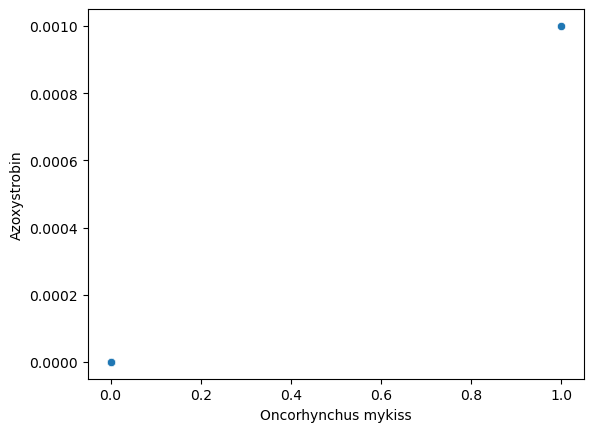

In [106]:
sns.scatterplot(data=azoxystrobin,x='Oncorhynchus mykiss',y='Azoxystrobin')

In [107]:
#encode compound names
le = LabelEncoder()
merged_dates_only['Compound_Name'] = le.fit_transform(merged_dates_only['Compound_Name'])
#recent_anglia_filtered['Compound_Name'] = le.fit_transform(recent_anglia_filtered['Compound_Name'])
mean_concentration_nans['Compound_Name'] = le.fit_transform(mean_concentration_nans['Compound_Name'])
#merged_forlinear.head()


In [108]:
#zero fill NANs and see
merged_dates_only_filled = merged_dates_only.dropna()
mean_concentration = mean_concentration_nans.dropna()
print(len(merged_dates_only_filled))
merged_dates_only_filled.head()
print(merged_dates_only_filled['LATIN_NAME'].unique())
#28 chemicals
print(len(merged_dates_only_filled['Compound_Name'].unique()))

#make dfs for each of 8 fish populations
rutilus_rutilus = mean_concentration.loc[mean_concentration['LATIN_NAME']=='Rutilus rutilus']
anguilla_anguilla = mean_concentration.loc[mean_concentration['LATIN_NAME']=='Anguilla anguilla']
salmo_trutta = mean_concentration.loc[mean_concentration['LATIN_NAME']=='Salmo trutta']
cyprinus_carpio = mean_concentration.loc[mean_concentration['LATIN_NAME']=='Cyprinus carpio']
phoxinus_phoxinus = mean_concentration.loc[mean_concentration['LATIN_NAME']=='Phoxinus phoxinus']
oncorhynchus_mykiss = mean_concentration.loc[mean_concentration['LATIN_NAME']=='Oncorhynchus mykiss']
carassius_auratus = mean_concentration.loc[mean_concentration['LATIN_NAME']=='Carassius auratus']
platichthys_flesus = mean_concentration.loc[mean_concentration['LATIN_NAME']=='Platichthys flesus']

print(len(mean_concentration))

1585
['Rutilus rutilus']
4
621


In [111]:
#normalize values
def normalize_fish_pop(df):
    normalized_conc_values = normalize(df[['Concentration','Compound_Name','SPCSNO',]])
    #normalized_mykiss_chems_array = normalize(merged_forlinear[['Compound_Name','Concentration','SPCSNO']])
    normalized_mykiss_chems = pd.DataFrame(normalized_conc_values,columns=['Compound_Name','Concentration','SPCSNO'])

    return df


#run linear regression for each species
rutilus_regression = normalize_fish_pop(rutilus_rutilus)
anguilla_regression = normalize_fish_pop(anguilla_anguilla)
trutta_regression = normalize_fish_pop(salmo_trutta)
carpio_regression = normalize_fish_pop(cyprinus_carpio)
phoxinus_regression = normalize_fish_pop(phoxinus_phoxinus)
mykiss_regression = normalize_fish_pop(oncorhynchus_mykiss)
auratus_regression = normalize_fish_pop(carassius_auratus)
flesus_regression = normalize_fish_pop(platichthys_flesus)
all_regression = normalize_fish_pop(mean_concentration)

rutilus_regression.head()

rutilus_regression.to_csv('rutilus_regression.tsv',sep='\t')
anguilla_regression.to_csv('anguilla_regression.tsv',sep='\t')
trutta_regression.to_csv('trutta_regression.tsv',sep='\t')
carpio_regression.to_csv('carpio_regression.tsv',sep='\t')
phoxinus_regression.to_csv('phoxinus_regression.tsv',sep='\t')
mykiss_regression.to_csv('mykiss_regression.tsv',sep='\t')
auratus_regression.to_csv('auratus_regression.tsv',sep='\t')
flesus_regression.to_csv('flesus_regression.tsv',sep='\t')
rutilus_rutilus.to_csv('rutilus_averaged.csv')
all_regression.to_csv('all_fish.csv')


anguilla_regression.head(50)
print(rutilus_regression['date_df2'].unique())

['2012-07-01T00:00:00.000000000' '2012-11-01T00:00:00.000000000'
 '2012-12-01T00:00:00.000000000' '2013-02-01T00:00:00.000000000'
 '2014-02-01T00:00:00.000000000' '2014-09-01T00:00:00.000000000'
 '2014-11-01T00:00:00.000000000' '2015-02-01T00:00:00.000000000'
 '2015-09-01T00:00:00.000000000' '2015-10-01T00:00:00.000000000'
 '2016-11-01T00:00:00.000000000' '2017-10-01T00:00:00.000000000'
 '2017-11-01T00:00:00.000000000' '2018-02-01T00:00:00.000000000'
 '2018-07-01T00:00:00.000000000' '2018-09-01T00:00:00.000000000'
 '2018-11-01T00:00:00.000000000' '2018-12-01T00:00:00.000000000'
 '2019-03-01T00:00:00.000000000' '2019-07-01T00:00:00.000000000'
 '2019-09-01T00:00:00.000000000' '2019-10-01T00:00:00.000000000'
 '2021-04-01T00:00:00.000000000' '2022-08-01T00:00:00.000000000']


In [153]:
#split into xtrain, ytrain, xtest, ytest and save 4 files to csv so they don't change
X = salmo_trutta[['Concentration','Compound_Name']]
y = salmo_trutta[['SPCSNO']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [154]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

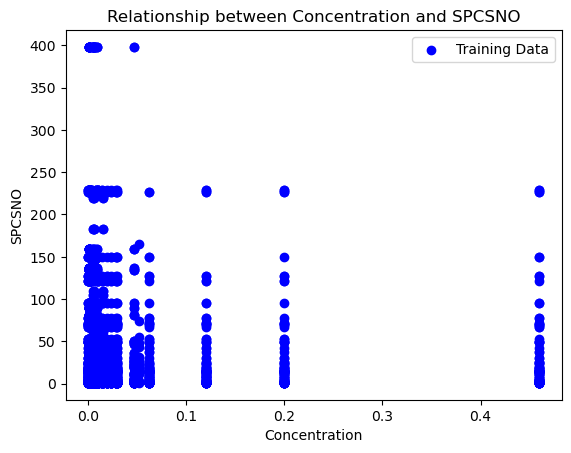

In [155]:
plt.scatter(X_train['Concentration'], y_train, color='blue', label='Training Data')
#plt.scatter(X_test['Concentration'], y_test, color='red', label='Testing Data')
plt.xlabel('Concentration')
plt.ylabel('SPCSNO')
plt.legend()
plt.title('Relationship between Concentration and SPCSNO')
plt.show()

In [112]:
predicted_fish_pops = pd.DataFrame(normalized_conc_values,columns=['Compound_Name','Concentration'])
predicted_fish_pops['SPCSNO'] = model.predict(normalized_conc_values)
predicted_fish_pops.head()
print(len(predicted_fish_pops))

ValueError: Shape of passed values is (15495, 3), indices imply (15495, 2)

In [113]:
r_sq = model.score(X, y)
print(r_sq)

0.8705501604699192


In [114]:
print(len(X_test))
print(len(y_test))

3099
3099


In [ ]:
sns.scatter(data

ValueError: x and y must be the same size

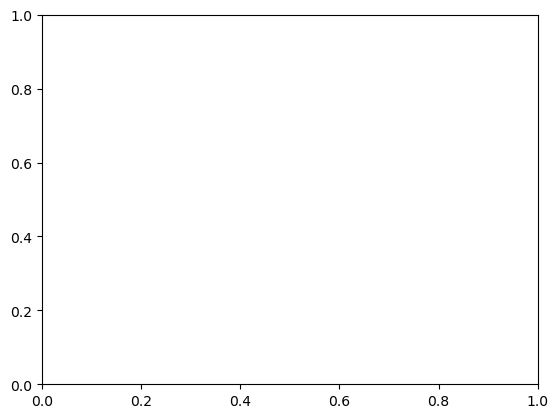

In [118]:
# Plot outputs
#one_chem = normalized_mykiss_chems.loc[normalized_mykiss_chems['Compound_Name']==0.970141]
#sns.scatterplot(data=predicted_fish_pops, x='Concentration',y='SPCSNO',hue='Compound_Name')
#plt.plot(X_test, y_pred, color="blue", linewidth=3)

plt.show()

normalized_mykiss_chems.to_csv('data_simple_linear.csv')
normalized_mykiss_chems.head()

In [43]:
X_train.to_csv('x_train.csv')
X_test.to_csv('x_test.csv')
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')

In [ ]:
#14 chemical toxic units test
#features to include
#be able to select toxic units for different species
#be able to drag slider for concentration levels at different locations
#dataframe includes
#resutl conc1 mean
#species name
#lat long values
#chemical names
#concentration

#